In [1]:
from numba.pycc import CC
from photon_circular import *
import numpy as np
from numba import typed, types
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from plot import *
from numpy import genfromtxt
from numba.cuda.random import init_xoroshiro128p_states
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib import cm
from scipy import optimize
from tqdm.notebook import trange, tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

def fit_func(x, const, a, b, c, d):
    return np.power(x, 3) * d + np.power(x, 2) * c + np.power(x, 2) * b + x * a + const


gridDim = 1
blockDim = 128
dim = gridDim * blockDim
all_adj_dist = []
all_collected = []
all_amps = []
all_modes = []
mode = 1.0
iters = 3 * 16
iters =512
NNxy = 500
NNr = int(NNxy/2)
NNz = int(NNxy/2)
degree_divs = 64
n_steps=100

np.random.seed(1)
s1 = genfromtxt(f's1_pm_{degree_divs}.txt', delimiter=',')
s2 = genfromtxt(f's2_pm_{degree_divs}.txt', delimiter=',')
m11 = genfromtxt(f'm11_pm_{degree_divs}.txt', delimiter=',')
m12 = genfromtxt(f'm12_pm_{degree_divs}.txt', delimiter=',')
temp = 1j * s1[:, 2]
temp += s1[:, 1]
s1 = temp
temp = 1j * s2[:, 2]
temp += s2[:, 1]
s2 = temp
m11 = m11[:, 1]
m12 = m12[:, 1]

s1 = np.ascontiguousarray(s1)
s2 = np.ascontiguousarray(s2)
m11 = np.ascontiguousarray(m11)
m12 = np.ascontiguousarray(m12)
cuda.pinned(s1)
cuda.pinned(s2)
cuda.pinned(m11)
cuda.pinned(m12)

co_xy_all = np.zeros((dim, NNxy, NNxy), dtype=np.float32)
co_rz_all = np.zeros((dim, NNr, NNz), dtype=np.float32)
co_rz_trad_all = np.zeros((dim, NNr, NNz), dtype=np.float32)
incoh_cross_xy_all=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
incoh_cross_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
cross_xy_all=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
cross_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
i_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
q_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
u_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
v_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)

ctr = 0
ctr_trad = 0
ctr_cross=0
# os.environ['NUMBA_DEBUG']='1'
 
for i in trange(iters, desc='1st loop'):
    mode = i % 3
    mode =3
    random_nums=np.random.rand(dim, n_steps * 10)
 
    d_modes =             cuda.to_device(np.ones(dim, dtype=np.float32) * mode)

    d_jones =             cuda.to_device(np.zeros((dim, 4), dtype=np.complex64))
    d_jones_partial =     cuda.to_device(np.zeros((dim, 4), dtype=np.complex64))
    d_U =                 cuda.to_device(np.zeros((dim, 3), dtype=np.float32))
    d_W =                 cuda.to_device(np.zeros(dim, dtype=np.float32))
    d_mu_as =             cuda.to_device(np.ones(dim, dtype=np.float32) * 0)
    d_mu_ss =             cuda.to_device(np.ones(dim, dtype=np.float32) * np.float(60))
    d_scat_events =       cuda.to_device(np.zeros(dim, dtype=np.float32))
    d_co_xy =             cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_cross_xy =          cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_incoh_cross_xy =    cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_co_rz =             cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_cross_rz =          cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_incoh_cross_rz =    cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_co_xy_trad =        cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_cross_xy_trad =     cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_incoh_cross_xy_trad=cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_co_rz_trad =        cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_cross_rz_trad =     cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_incoh_cross_rz_trad=cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_position =          cuda.to_device(np.zeros((NNxy, 3), dtype=np.float32))
    d_i_stokes_rz=        cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_q_stokes_rz =       cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_u_stokes_rz =       cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_v_stokes_rz =       cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_random_nums =       cuda.to_device(random_nums)
 
    rng_states=1
    seed = i
 
    process_steps_circ[gridDim, blockDim](seed,  rng_states , d_modes,d_random_nums, d_U, d_W, d_jones, d_mu_as,
                                     d_mu_ss, d_scat_events, d_jones_partial, d_co_xy, d_cross_xy, d_incoh_cross_xy, d_co_rz, d_cross_rz,
                                     d_incoh_cross_rz, d_co_xy_trad, d_cross_xy_trad, d_incoh_cross_xy_trad, d_co_rz_trad, d_cross_rz_trad,
                                     d_incoh_cross_rz_trad, d_position, s1, s2, m11, m12,d_i_stokes_rz,d_q_stokes_rz,d_u_stokes_rz,d_v_stokes_rz)
 
    co_xy=d_co_xy.copy_to_host()
    cross_xy=d_cross_xy.copy_to_host()
    incoh_cross_xy=d_incoh_cross_xy.copy_to_host()
    co_rz=d_co_rz.copy_to_host()
    cross_rz=d_cross_rz.copy_to_host()
    incoh_cross_rz=d_incoh_cross_rz.copy_to_host()
    co_xy_trad=d_co_xy_trad.copy_to_host()
    cross_xy_trad=d_cross_xy_trad.copy_to_host()
    incoh_cross_xy_trad=d_incoh_cross_xy_trad.copy_to_host()
    co_rz_trad=d_co_rz_trad.copy_to_host()
    cross_rz_trad=d_cross_rz_trad.copy_to_host()
    incoh_cross_rz_trad=d_incoh_cross_rz_trad.copy_to_host()
    position=d_position.copy_to_host()
    i_stokes_rz = d_i_stokes_rz.copy_to_host()
    q_stokes_rz = d_q_stokes_rz.copy_to_host()
    u_stokes_rz = d_u_stokes_rz.copy_to_host()
    v_stokes_rz = d_v_stokes_rz.copy_to_host()
    # nb.cuda.profile_stop()

    # all_adj_dist.append(adjusted_dist)
    # all_collected.append(collected)
    # all_amps.append(amplitudes)
    # all_modes.append(modes)
    
    i_stokes_rz_all+=i_stokes_rz
    q_stokes_rz_all+=q_stokes_rz
    u_stokes_rz_all+=u_stokes_rz
    v_stokes_rz_all+=v_stokes_rz
    
    if not(np.isnan(co_rz.max())):
        co_rz_all += co_rz
        co_xy_all += co_xy  
        
        ctr+=1
        print(ctr, 'partial',co_rz.max())
    if not(np.isnan(co_rz_trad.max())):
        co_rz_trad_all+=co_rz_trad
        ctr_trad+=1
        print(ctr_trad, 'trad',co_rz_trad.max())
        
    if not (np.isnan(incoh_cross_xy_all.max())):
        incoh_cross_xy_all+=incoh_cross_xy        
        
        incoh_cross_rz_all+=incoh_cross_rz      
        ctr_cross+=1
    if not (np.isnan(cross_xy_all.max())):
        cross_xy_all+=cross_xy
        cross_rz_all+=cross_rz
 

1 partial 637.8706
1 trad 0.0
2 partial 629.97424
2 trad 0.0
3 partial 631.78754
3 trad 0.0
4 partial 636.66144
4 trad 0.0
5 partial 640.05817
5 trad 0.0
6 partial 630.83
6 trad 0.0
7 partial 631.4058
7 trad 0.0
8 partial 633.5985
8 trad 0.0
9 partial 629.37836
9 trad 0.0
10 partial 641.3757
10 trad 0.0
11 partial 634.1077
11 trad 0.0
12 partial 637.503
12 trad 0.0
13 partial 1049.1195
13 trad 0.0
14 partial 634.65533
14 trad 0.0
15 partial 635.286
15 trad 0.0
16 partial 638.10846
16 trad 0.0
17 partial 625.0672
17 trad 0.0
18 partial 640.03723
18 trad 0.0
19 partial 638.7337
19 trad 0.0
20 partial 637.5927
20 trad 0.0
21 partial 635.24524
21 trad 0.0
22 partial 666.8381
22 trad 0.0
23 partial 638.4091
23 trad 0.0
24 partial 639.5546
24 trad 0.0
25 partial 637.97565
25 trad 0.0
26 partial 641.6661
26 trad 0.0
27 partial 634.3508
27 trad 0.0
28 partial 637.57587
28 trad 0.0
29 partial 639.17804
29 trad 0.0
30 partial 617.4713
30 trad 0.0
31 partial 641.01917
31 trad 0.0
32 partial 641.1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


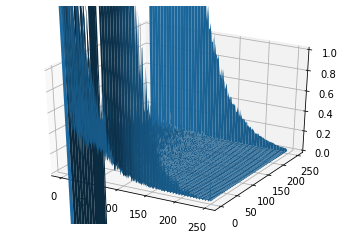

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%load_ext autoreload
%autoreload 2

grid_size = NNr
x = np.sum(co_rz_all, axis=0)
#print(np.unique(co_rz_all))
x[0,0]=0
x[grid_size-1,grid_size-1]=0
# mean = np.mean(x)
# std = np.std(x)
# x = (x - mean) / std
x/=ctr
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(grid_size), range(grid_size))  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X, Y, x)
ax.set_zlim(0, 1)
plt.show()

C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


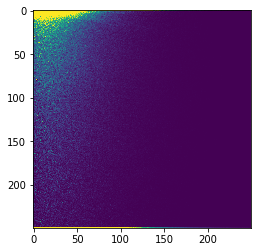

In [3]:
x_clipped=x/x.max()
x_clipped=np.log(x_clipped)
x_clipped=np.clip(x,0,1)
plt.imshow(x_clipped)
plt.show()



C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


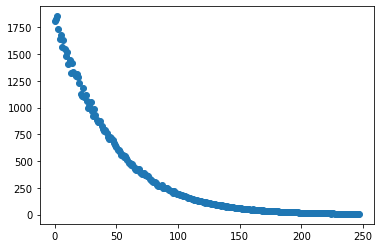

In [4]:
import numpy as np 
import matplotlib.pyplot as plt

grid_size = NNr
i_all = np.mean(i_stokes_rz_all[:,1:-1,1:-1], axis=0)
q_all = np.mean(q_stokes_rz_all[:,1:-1,1:-1], axis=0)
u_all = np.mean(u_stokes_rz_all[:,1:-1,1:-1], axis=0)
v_all = np.mean(v_stokes_rz_all[:,1:-1,1:-1], axis=0)

i_z=np.zeros(len(i_all[0,:]))
q_z=np.zeros(len(q_all[0,:]))
u_z=np.zeros(len(u_all[0,:]))
v_z=np.zeros(len(v_all[0,:]))
for i in range(len(i_z)):
    sum=np.sqrt(pow(q_all[i,i],2)+pow(u_all[i,i],2)+pow(v_all[i,i],2))
    i_z[i]=i_all[i,i]/sum
    q_z[i]=q_all[i,i]/sum
    u_z[i]=u_all[i,i]/sum
    v_z[i]=v_all[i,i]/sum

sum_quv=np.sqrt(np.power(q_all,2)+np.power(u_all,2)+np.power(v_all,2))
sum_quv[sum_quv==0]=1
# i_all/=sum_quv
# q_all/=sum_quv
# u_all/=sum_quv
# v_all/=sum_quv

i_all=np.sum(i_all,axis=0)
q_all=np.sum(q_all,axis=0)
u_all=np.sum(u_all,axis=0)
v_all=np.sum(v_all,axis=0)
polarizability =(np.power(q_all,2)+np.power(u_all,2)+np.power(v_all,2))/np.power(i_all,2)
xx=np.sum(incoh_cross_rz_all,axis=0)
xx=np.sum(xx[1:-1,1:-1],axis=0)
data=[xx]

# data=[i_z,q_z,u_z,v_z]
for i in range(len(data)):        
        r=np.abs(data[i]/i_all)
        # r_clipped=r/r.max()
        # r_clipped=np.clip(r_clipped,0,1)
        plt.plot(r,'o')
# plt.plot(q_all/q_all.max(),'o')
# plt.plot(u_all/u_all.max(),'o')
# plt.plot(v_all/v_all.max(),'o')
# plt.legend(['I^2',"Q^2", "U^2",'V^2','Polar'])
# plt.ylim([0,1])
plt.show()

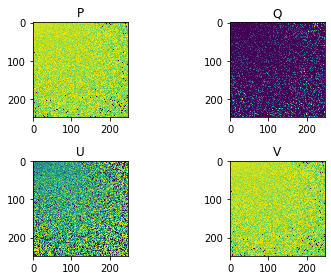

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from PIL import Image

i_all = np.sum(i_stokes_rz_all[:,1:-1,1:-1], axis=0)
q_all = np.sum(q_stokes_rz_all[:,1:-1,1:-1], axis=0)
u_all = np.sum(u_stokes_rz_all[:,1:-1,1:-1], axis=0)
v_all = np.sum(v_stokes_rz_all[:,1:-1,1:-1], axis=0)
sum_quv=np.sqrt(np.power(q_all,2)+np.power(u_all,2)+np.power(v_all,2))
sum_quv[sum_quv==0]=1
i_all/=sum_quv
q_all/=sum_quv
u_all/=sum_quv
v_all/=sum_quv

# 
data=[i_all,q_all,u_all,v_all]
titles=['P','Q','U','V']
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)
for i in range(2):
    for j in range(2):
        indx=i*2+j
        r=data[indx]
        r_clipped=r/r.max()
        r_clipped=np.clip(r_clipped,0,1)
        ax=fig.add_subplot(gs[i,j])
        
        # c = Image.fromarray(r_clipped*255)
        # d = c.resize((2000,2000), resample=Image.BICUBIC)
        ax.set_title(titles[indx])
        ax.imshow(r_clipped)
        

plt.show()

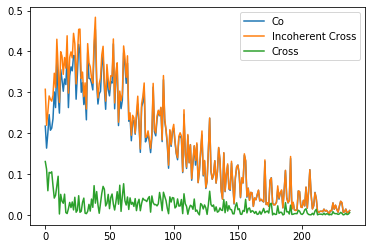

In [6]:
import numpy as np 
import matplotlib.pyplot as plt

grid_size = NNr
co=np.sum(co_rz_all,axis=0)
incoh_cross=np.sum(incoh_cross_rz_all ,axis=0)
cross=np.sum(cross_rz_all,axis=0)

i_all = np.sum(i_stokes_rz_all[:,1:-1,1:-1], axis=0)
# i_all=np.mean(i_all[:,:5],axis=1)
co= co[0,1:-1]
incoh_cross=incoh_cross[0,1:-1]
cross=cross[0,1:-1]
data=[co,incoh_cross,cross]
# data=[np.mean(co[1:-1,0:5],axis=1),np.mean(incoh_cross[1:-1,0:5],axis=1),np.mean(cross[1:-1,0:5],axis=1)]
xx=i_all[0,:][i_all[0,:]>0]
[i_all[0,:]>0]
for i in range(len(data)):        
        r=np.abs(data[i][i_all[0,:]>0] /xx)/512
        # r_clipped=r/r.max()
        # r_clipped=np.clip(r_clipped,0,1)
        plt.plot(r,'-')
 
plt.legend(['Co','Incoherent Cross','Cross'])
# plt.ylim([0,1])
plt.show()

1984.2485
3735.73
3058.2605


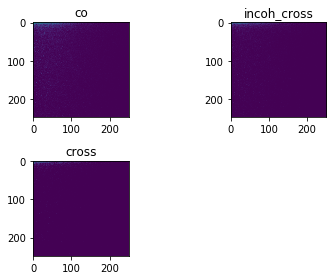

In [8]:
co=np.sum(co_rz_all,axis=0)
incoh_cross=np.sum(incoh_cross_rz_all ,axis=0)
cross=np.sum(cross_rz_all,axis=0)

data=[co[1:-1],incoh_cross[1:-1],cross[1:-1]]
titles=['co','incoh_cross','cross','zero']
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)
for i in range(2):
    for j in range(2):
        if i==1 and j ==1:
            break
        indx=i*2+j
        r=data[indx]
        print(r.max())
        r_clipped=r/r.max()
        # r_clipped=(r_clipped-r_clipped.mean())/r_clipped.std()
        r_clipped=np.clip(r_clipped,0,1)
        ax=fig.add_subplot(gs[i,j])
        
        # c = Image.fromarray(r_clipped*255)
        # d = c.resize((2000,2000), resample=Image.BICUBIC)
        ax.set_title(titles[indx])
        ax.imshow(r_clipped)
        

plt.show()

In [2]:
#SAVE
import numpy as np
import os

dx=4e-4
dr=dx
no=1.33
ne=1.33
chi=5.36e-5
SAVEDIR='data'
if not os.path.isdir(os.path.join(SAVEDIR)):
    os.mkdir(SAVEDIR)
vars=[     
co_xy_all ,
co_rz_all ,
co_rz_trad_all ,
incoh_cross_xy_all ,
incoh_cross_rz_all ,
cross_xy_all ,
cross_rz_all ,
i_stokes_rz_all ,
q_stokes_rz_all ,
u_stokes_rz_all ,
v_stokes_rz_all 
]
vars_names=[
'co_xy_all',
'co_rz_all',
'co_rz_trad_all',
'incoh_cross_xy_all',
'incoh_cross_rz_all',
'cross_xy_all',
'cross_rz_all',
'i_stokes_rz_all',
'q_stokes_rz_all',
'u_stokes_rz_all',
'v_stokes_rz_all'
]
for var, var_name in zip(vars,vars_names):
    np.save(os.path.join(SAVEDIR,var_name+'.npy'),var)
    
params=[NNxy,NNr,NNz,iters,dx,dr,dim,no,ne,]  
params_names=['NNxy','NNr','NNz','iters','dx','dr','dim','no','ne','chi']  
with open(os.path.join(SAVEDIR,'params.txt'),'w') as f:
    for param, param_name in zip(params, params_names):
        f.write(param_name+'='+str(param))

In [23]:
#LOAD
import numpy as np
import os
LOADDIR='data\data2'

gridDim = 4
blockDim = 128
dim = gridDim * blockDim
NNxy = 400
NNr = int(NNxy/2)
NNz = int(NNxy/2)

co_xy_all = np.zeros((dim, NNxy, NNxy), dtype=np.float32)
co_rz_all = np.zeros((dim, NNr, NNz), dtype=np.float32)
co_rz_trad_all = np.zeros((dim, NNr, NNz), dtype=np.float32)
incoh_cross_xy_all=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
incoh_cross_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
cross_xy_all=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
cross_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
i_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
q_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
u_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
v_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)

vars=[     
co_xy_all ,
co_rz_all ,
co_rz_trad_all ,
incoh_cross_xy_all ,
incoh_cross_rz_all ,
cross_xy_all ,
cross_rz_all ,
i_stokes_rz_all ,
q_stokes_rz_all ,
u_stokes_rz_all ,
v_stokes_rz_all ,
]
vars_names=[
'co_xy_all',
'co_rz_all',
'co_rz_trad_all',
'incoh_cross_xy_all',
'incoh_cross_rz_all',
'cross_xy_all',
'cross_rz_all',
'i_stokes_rz_all',
'q_stokes_rz_all',
'u_stokes_rz_all',
'v_stokes_rz_all'
]
for i, var_name in enumerate(vars_names):
    vars[i][:,:,:]=np.load(os.path.join(LOADDIR,var_name+'.npy'))
 
 

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from PIL import Image

i_all = np.sum(i_stokes_rz_all[:,1:-1,1:-1], axis=0)
q_all = np.sum(q_stokes_rz_all[:,1:-1,1:-1], axis=0)
u_all = np.sum(u_stokes_rz_all[:,1:-1,1:-1], axis=0)
v_all = np.sum(v_stokes_rz_all[:,1:-1,1:-1], axis=0)
sum_quv=np.sqrt(np.power(q_all,2)+np.power(u_all,2)+np.power(v_all,2))
sum_quv[sum_quv==0]=1
i_all/=sum_quv
q_all/=sum_quv
u_all/=sum_quv
v_all/=sum_quv

array([1., 4., 1., 2., 1., 4., 3., 2., 2., 5., 3., 2., 1., 1., 1., 1., 2.,
       1., 3., 1., 2., 1., 2., 1., 1., 2., 2., 2., 1., 2., 2., 1., 2., 4.,
       1., 3., 2., 3., 1., 2., 4., 1., 2., 1., 1., 1., 1., 1., 4., 3., 2.,
       3., 4., 1., 2., 1., 2., 3., 1., 1., 3., 1., 3., 1., 1., 1., 1., 2.,
       2., 3., 2., 1., 2., 1., 1., 2., 1., 2., 3., 2., 2., 1., 2., 1., 4.,
       3., 2., 3., 3., 3., 1., 4., 1., 1., 3., 1., 3., 1., 1., 1., 4., 2.,
       3., 2., 3., 2., 3., 3., 3., 2., 2., 1., 3., 3., 2., 1., 2., 2., 1.,
       2., 1., 5., 2., 3., 4., 3., 2., 2., 2., 2., 2., 3., 2., 2., 3., 1.,
       5., 4., 1., 1., 3., 2., 2., 2., 4., 2., 7., 1., 2., 1., 1., 2., 1.,
       1.], dtype=float32)

In [116]:
co_sum=np.sum(co_rz_all[1:-1,1:-1])
incoh_sum=np.sum(np.abs(incoh_cross_rz_all[1:-1,1:-1]))
cross_sum=np.sum(np.abs(cross_rz_all[1:-1,1:-1]))
all_sum=co_sum+incoh_sum+cross_sum
print(co_sum/all_sum)

0.421188
